# Demo SEA data calculations
This demonstrates the use of low-level routines to replicate signal analysis performed by SEA.

Each analysis product is returned as a `xarray.DataArray`. At the end, they are merged into a single `xarray.Dataset` containing all all the different data results along with their labels, coordinates, and metadata.

### Generate fake data

In [1]:
import matplotlib
import iqwaveform.figures
import numpy as np
import channel_analysis

N=10
capture = channel_analysis.FilteredCapture(sample_rate=N*15.36e6, analysis_bandwidth=N*10e6, duration=0.1)
iq = channel_analysis.simulated_awgn(capture, xp=np)

### Channel power time-series

In [2]:
pvt = channel_analysis.channel_power_time_series(
    iq,
    capture,
    detector_period=10e-3,
    power_detectors=('rms', 'peak'),
).to_xarray()

In [3]:
%%timeit -n1 -r1

channel_analysis.channel_power_time_series(
    iq,
    capture,
    detector_period=10e-3,
    power_detectors=('rms', 'peak'),
).to_xarray()

238 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


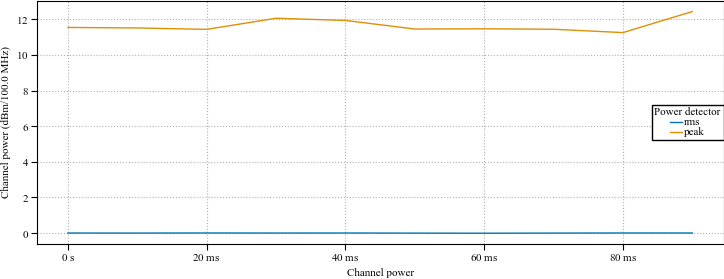

In [4]:
from iqwaveform import powtodB
from matplotlib import pyplot as plt
from channel_analysis import figures

plt.style.use('iqwaveform.ieee_double_column')

fig, ax = plt.subplots()

pvt.plot.line(x='time_elapsed', ax=ax)

figures.label_axis(ax.xaxis, pvt, 'time_elapsed')
figures.label_axis(ax.yaxis, pvt, tick_units=False)
figures.label_legend(ax, pvt, 'power_detector')

### Cyclic channel power

In [5]:
# cyclic_power = channel_analysis.cyclic_channel_power(
#     iq,
#     capture,
#     cyclic_period=10e-3,
#     detector_period=1e-3 / 15 / 4,
#     power_detectors=('rms', 'peak'),
#     cyclic_statistics=('min', 'mean', 'max'),
# ).to_xarray()

: 

### Cellular cyclic autocorrelation

In [6]:
cyclic_autocorrelation = channel_analysis.cellular_cyclic_autocorrelation(
    iq,
    capture,
    subcarrier_spacings=(15e3, 30e3, 60e3),
    frame_range=(0,1),
    # slot_range=(0,1),
    symbol_range=(0,1)
).to_xarray()

int32


In [ ]:
%%timeit -n1 -r1 

cyclic_autocorrelation = channel_analysis.cellular_cyclic_autocorrelation(
    iq,
    capture,
    subcarrier_spacings=(15e3, 30e3, 60e3),
    frame_range=(0,1),
    # slot_range=(0,1),
    symbol_range=(0,1)
).to_xarray()

int32


In [9]:
from channel_analysis.xarray_wrappers._cellular_cyclic_autocorrelation import _correlate_along_axis

locals().update(channel_analysis.xarray_wrappers._cellular_cyclic_autocorrelation.debug)

%timeit -n1 -r1 _correlate_along_axis(iq[cp_inds], iq[cp_inds+nfft], (0,1), norm=True)

(0, 1)
552 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [10]:
%timeit -n1 -r1 _correlate_along_axis(iq[cp_inds], np.conj(iq[nfft:][cp_inds]), (0,1), norm=True)
%timeit -n1 -r1 _correlate_along_axis(a, np.conj(b), (0,1), norm=True)

(0, 1)
546 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
(0, 1)
364 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [11]:
import numba as nb

# @nb.njit(
#     nb.void(
#         nb.complex64[:],
#         nb.int_[:],
#         nb.int_,
#         nb.complex64[:],
#         nb.complex64[:],
#         nb.complex64[:],
#         nb.float32[:],
#     ),
#     parallel=True,
# )
# def _direct_correlation_axis1(x, inds, fft_size):
#     """accelerated evaluation of the inner cyclic prefix indexing loop"""

#     for i in nb.prange(inds.size):
#         i_here = inds[i]
#         a_here = a[i] = x[i_here + fft_size]
#         b_here = b[i] = x[i_here]
#         power[i] = 0.5 * (np.abs(a_here) ** 2 + np.abs(b_here) ** 2)
#         summand[i] = a_here * np.conj(b_here)


In [12]:
# @nb.guvectorize(
#     [
#         (nb.complex64[:], nb.int32[:,:], nb.int32[:], nb.complex64[:]),
#         (nb.complex64[:], nb.int64[:,:], nb.int32[:], nb.complex64[:]),
#         (nb.complex64[:], nb.int32[:,:], nb.int64[:], nb.complex64[:]),
#         (nb.complex64[:], nb.int64[:,:], nb.int64[:], nb.complex64[:]),
#     ],
#     '(k),(m,l),()->(l)',
# )
# def _direct_correlation_numba(x, inds, nfft, out):
#     shape = inds.shape
#     i = inds.flatten()
#     a = x[i].reshape(shape)
#     b = np.conj(x[i+nfft]).reshape(shape)
#     out[:] = np.sum(a*b, axis=0)

import numba as nb
import numba.cuda
import cupy as cp
import math
import array_api_compat


@nb.njit(
    [
        (nb.int32[:,:], nb.complex64[:], nb.int32, nb.boolean, nb.complex64[:]),
        (nb.int32[:,:], nb.complex64[:], nb.int64, nb.boolean, nb.complex64[:]),
        (nb.int64[:,:], nb.complex64[:], nb.int32, nb.boolean, nb.complex64[:]),
        (nb.int64[:,:], nb.complex64[:], nb.int64, nb.boolean, nb.complex64[:]),
    ],
    parallel=True
)
def _corr_cyclic_prefix_cpu(inds, x, nfft, norm, out):
    for j in nb.prange(inds.shape[1]):
        accum_corr = nb.complex128(0+0j)
        accum_power_a = nb.float64(0.0)
        accum_power_b = nb.float64(0.0)
        for i in range(inds.shape[0]):
            ix = inds[i,j]
            a = x[ix]
            b = x[ix+nfft].conjugate()
            accum_corr += a*b
            if norm:
                accum_power_a += a.real*a.real+a.imag*a.imag
                accum_power_b += b.real*b.real+b.imag*b.imag

        if norm:
            # normalized by the standard deviation, assuming zero-mean 
            accum_corr /= math.sqrt(accum_power_a*accum_power_b)/inds.shape[0]

        out[j] = accum_corr


@nb.cuda.jit(
    [
        (nb.int32[:,:], nb.complex64[:], nb.int32, nb.boolean, nb.complex64[:]),
        (nb.int32[:,:], nb.complex64[:], nb.int64, nb.boolean, nb.complex64[:]),
        (nb.int64[:,:], nb.complex64[:], nb.int32, nb.boolean, nb.complex64[:]),
        (nb.int64[:,:], nb.complex64[:], nb.int64, nb.boolean, nb.complex64[:]),
    ],
)
def _corr_by_index(inds, x, nfft, norm, out):
    j = nb.cuda.grid(1)

    if j < inds.shape[1]:
        accum_corr = nb.complex128(0+0j)
        accum_power_a = nb.float64(0.0)
        accum_power_b = nb.float64(0.0)
        for i in range(inds.shape[0]):
            ix = inds[i,j]
            a = x[ix]
            b = x[ix+nfft].conjugate()
            accum_corr += a*b
            if norm:
                accum_power_a += a.real*a.real+a.imag*a.imag
                accum_power_b += b.real*b.real+b.imag*b.imag

        if norm:
            # normalized by the standard deviation, assuming zero-mean 
            accum_corr /= math.sqrt(accum_power_a*accum_power_b)/inds.shape[0]

        out[j] = accum_corr

def optimized_correlation(inds, x, nfft, norm=True, out=None):
    xp = iqwaveform.util.array_namespace(x)
    if out is None:
        out = xp.empty(inds.shape[1], dtype=x.dtype)

    if inds.ndim > 2:
        new_shape = np.prod(inds.shape[:-1]), inds.shape[-1]
        inds = inds.reshape(new_shape)

    if xp is array_api_compat.cupy:
        tpb = 64
        bpg = (iq.size + (tpb - 1)) // tpb
        _corr_by_index[bpg,tpb](inds, x, nfft, norm, out)

    if xp is array_api_compat.numpy:
        _corr_cyclic_prefix_cpu(inds, x, nfft, norm, out)

    return out

def direct_correlation(x, inds, nfft, out):
    xp = iqwaveform.util.array_namespace(x)

    shape = inds.shape
    i = inds.flatten()
    a = x[i].reshape(shape)
    b = xp.conj(x[i+nfft]).reshape(shape)
    return xp.sum(a*b, axis=0, out=out)    

In [13]:
cyclic_autocorrelation[-1].values

array([0.01087144, 0.00962018, 0.00937739, ...,        nan,        nan,
              nan], dtype=float32)

In [14]:
# # out = np.empty(cp_inds.shape[-1], dtype='complex64')
# # out_simple = np.empty(cp_inds.shape[-1], dtype='complex64')
# # cp_flat = cp_inds.reshape((np.prod(cp_inds.shape[:-1]), cp_inds.shape[-1]))
# # %timeit -n1 -r1 _direct_correlation(iq, cp_flat, nfft, out_simple)
# # %timeit -n1 -r1 _direct_correlation_numba(cp_flat, iq, nfft, out)

iq_cp = cp.asarray(iq)
cp_cp_inds = cp.asarray(cp_inds)

optimized_correlation(cp_cp_inds, iq_cp, nfft).get();
optimized_correlation(cp_inds, iq, nfft);
# %timeit -n1 -r1 _direct_correlation(cp_cp_inds, iq_cp, nfft).get()
# %timeit -n1 -r1 out_cp.get()

# # # out[:] /= np.prod(cp_inds.shape[:-1])

# # out

TypeError: No matching definition for argument type(s) array(int32, 2d, C), array(complex64, 1d, C), int64, bool, array(complex64, 1d, C)

In [21]:
%%timeit
optimized_correlation(cp_cp_inds, iq_cp, nfft).get();

: 

In [1]:
%%timeit
optimized_correlation(cp_inds, iq, nfft);

NameError: name 'optimized_correlation' is not defined

In [123]:
result_cupy = optimized_correlation(cp_cp_flat, iq_cp, nfft).get()
result_numpy = optimized_correlation(cp_flat, iq, nfft)

In [14]:
%%timeit -n1 -r1

cyclic_autocorrelation = channel_analysis.cellular_cyclic_autocorrelation(
    iq,
    capture,
    subcarrier_spacings=(15e3, 30e3, 60e3),
    frame_range=(0,1),
    # slot_range=(0,1),
    symbol_range=(0,1)
).to_xarray()

int32
(0, 1)
int32
(0, 1)
int32
(0, 1)
2.99 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


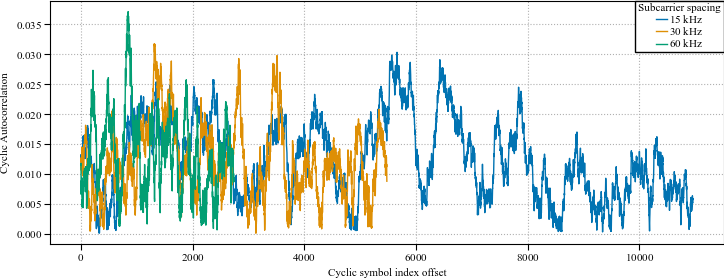

In [15]:
fig, ax = plt.subplots()

cyclic_autocorrelation.plot.line(x='cyclic_sample_lag', ax=ax)
figures.label_legend(ax, cyclic_autocorrelation, 'subcarrier_spacing')

### Persistence Spectrum

In [16]:
frequency_resolution = 1e3
spectrum_quantiles = [0.5, 0.75, 0.95, 0.99, 1]

spectrum = channel_analysis.persistence_spectrum(
    iq,
    capture,
    window=('dpss', 5),
    frequency_resolution=frequency_resolution,
    persistence_statistics=spectrum_quantiles,
    fractional_overlap=0.0,
    truncate=False,
).to_xarray()

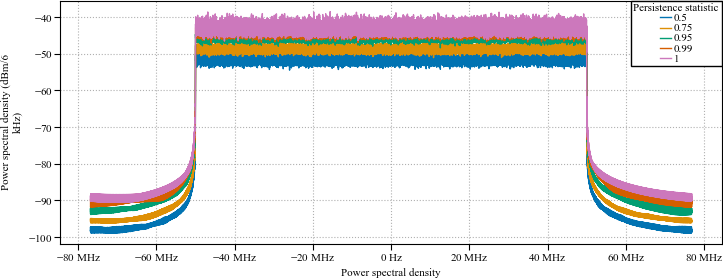

In [17]:
fig, ax = plt.subplots()

spectrum.plot.line(x='baseband_frequency', ax=ax)
figures.label_axis(ax.xaxis, spectrum, 'baseband_frequency')
# figures.label_legend(ax, spectrum, 'persistence_statistic')

In [18]:
%%timeit -n1 -r1 

spectrum = channel_analysis.persistence_spectrum(
    iq,
    capture,
    window=('dpss', 5),
    frequency_resolution=frequency_resolution,
    persistence_statistics=spectrum_quantiles,
    fractional_overlap=0.0,
    truncate=True,
).to_xarray()

800 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Spectrogram Power Distribution

In [19]:
spectrogram_ccdf = channel_analysis.spectrogram_power_ccdf(
    iq,
    capture,
    window=('dpss', 5),
    power_low=-90,
    power_high=0,
    power_resolution=0.25,
    frequency_resolution=15e3,
    fractional_overlap=0.0,
).to_xarray()

Error in callback <function _draw_all_if_interactive at 0x0000025E3C55A790> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

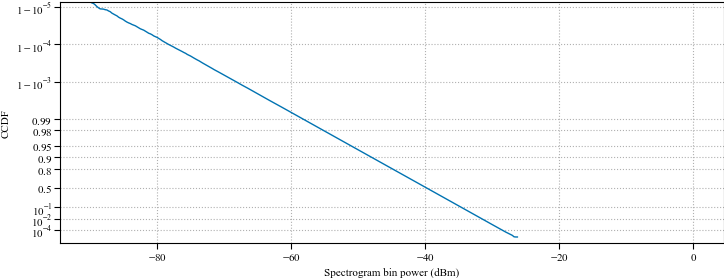

In [20]:
fig, ax = plt.subplots()

# figures.label_axis(ax.xaxis, spectrum, 'baseband_frequency')
# figures.label_legend(ax, spectrum, 'persistence_statistic')
spectrogram_ccdf[spectrogram_ccdf.values < 1].plot(ax=ax)

# ax.set_ylim(1e-8, 1-1e-5)
ax.set_yscale('gamma-qq', k=1, major_ticks=12, db_ordinal=True)
# figures.label_axis(ax.xaxis, spectrogram_ccdf,  'channel_power_bin', tick_units=False)
# figures.label_axis(ax.yaxis, spectrogram_ccdf)

In [16]:
%%timeit -n1 -r1 

spectrum = channel_analysis.persistence_spectrum(
    iq,
    capture,
    window=('dpss', 5),
    frequency_resolution=frequency_resolution,
    persistence_statistics=spectrum_quantiles,
    fractional_overlap=0.0,
    truncate=True,
).to_xarray()

750 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Power sample CCDF

In [17]:
apd_bins = dict(power_low=-60.0, power_high=15.0, power_resolution=0.25)

apd = channel_analysis.channel_power_ccdf(iq, capture, **apd_bins).to_xarray()

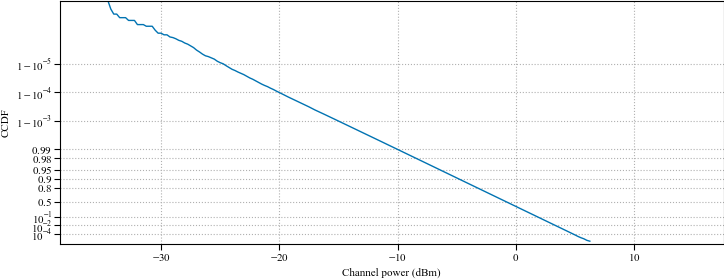

In [18]:
import iqwaveform.figures
fig, ax = plt.subplots()
apd[apd.values < 1].plot(ax=ax)

# ax.set_ylim(1e-8, 1-1e-5)
ax.set_yscale('gamma-qq', k=1, major_ticks=12, db_ordinal=True)
figures.label_axis(ax.xaxis, apd,  'channel_power_bin', tick_units=False)
figures.label_axis(ax.yaxis, apd)

### Putting it all together

In [19]:
# %%timeit -n1 -r1

del iq

iq = channel_analysis.simulated_awgn(capture, xp=np)
iq = channel_analysis.filter_iq_capture(iq, capture)

analysis_spec = {
    'channel_power_time_series': {'detector_period': 10e-3, 'power_detectors': ('rms', 'peak')},
    'cyclic_channel_power': {
        'cyclic_period': 10e-3,
        'detector_period': 1e-3 / 15 / 4,
        'power_detectors': ('rms', 'peak'),
        'cyclic_statistics': ('min', 'mean', 'max'),
    },
    'persistence_spectrum': {
        # 'window': 'flattop',
        'window': 'hamming',  # 'hamming', 'blackman', or 'blackmanharris'
        'frequency_resolution':1e3,
        'persistence_statistics': [0.5, 0.75, 0.95, 0.99, 1],
        'truncate': False,
    },
    'channel_power_ccdf': {
        'power_low': -40,
        'power_high': 15,
        'power_resolution': 221,  # 0.25 dB resolution
    },
}

filter_spec = {
    'nfft': 1024,
    'window': 'hamming',  # 'hamming', 'blackman', or 'blackmanharris'
}

result =  channel_analysis.analyze_by_spec(iq, capture, spec=analysis_spec)
result

<xarray.Dataset> Size: 4MB
Dimensions:                    (channel_power_bin: 1, power_detector: 2,
                                time_elapsed: 10, cyclic_statistic: 3,
                                cyclic_lag: 600, persistence_statistic: 5,
                                baseband_frequency: 153600)
Coordinates:
  * channel_power_bin          (channel_power_bin) float32 4B -40.0
  * power_detector             (power_detector) object 16B 'rms' 'peak'
  * time_elapsed               (time_elapsed) float32 40B 0.0 0.01 ... 0.08 0.09
  * cyclic_statistic           (cyclic_statistic) object 24B 'min' 'mean' 'max'
  * cyclic_lag                 (cyclic_lag) float32 2kB 0.0 ... 0.009983
  * persistence_statistic      (persistence_statistic) object 40B '0.5' ... '...
  * baseband_frequency         (baseband_frequency) float64 1MB -7.68e+07 ......
Data variables:
    channel_power_ccdf         (channel_power_bin) float32 4B 1.0
    channel_power_time_series  (power_detector, time_elapsed) float32 80B -0....
    cyclic_channel_power       (power_detector, cyclic_statistic, cyclic_lag) float32 14kB ...
    persistence_spectrum       (persistence_statistic, baseband_frequency) float32 3MB ...
Attributes:
    analysis_filter:     {'nfft': 8192, 'window': 'hamming'}
    duration:            0.1
    sample_rate:         153600000.0
    analysis_bandwidth:  100000000.0

In [20]:
%%timeit -n1 -r1

channel_analysis.analyze_by_spec(
    iq,
    capture,
    spec=analysis_spec,
)

1.52 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [21]:
%timeit -n1 -r1 channel_analysis.dump('test.zarr.zip', result, mode='w')

TypeError: dump() got an unexpected keyword argument 'mode'